## Fine-Tuning deepset/gbert-base for German Hate Speech Classification
This notebook fine-tunes `deepset/gbert-base` on a German hate speech dataset using PyTorch, BERT and CNN Layer.

This script is used for training just one model on specific (manually chosen) hyperparameters.

The script automatically logs the model metrics to the wandb project as well as to "logged_model_metrics.xlsx"


Inspiration for this setup: <br>

Cendra Devayana Putra, Hei-Chia Wang,
Advanced BERT-CNN for Hate Speech Detection,
Procedia Computer Science,
Volume 234,
2024,
Pages 239-246,
ISSN 1877-0509,
https://doi.org/10.1016/j.procs.2024.02.170.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import wandb
import optuna
from optuna.pruners import HyperbandPruner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score
    , accuracy_score
    , precision_recall_fscore_support
    , matthews_corrcoef
    , classification_report
    , f1_score
    , log_loss
    , precision_score
    , recall_score
    , fbeta_score
    , confusion_matrix
    , ConfusionMatrixDisplay
)
from transformers import AutoTokenizer, BertModel, Trainer, TrainingArguments
import logging
import os
from google.colab import runtime, userdata, drive
import datetime
import threading
import time

## Set up logging and connections

In [ ]:
# Configure Logging
logging.basicConfig(
    level=logging.INFO,  # Log INFO
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True
)

logger = logging.getLogger(__name__)

# empty cache
torch.cuda.empty_cache()

In [ ]:
# connect to wandb
wandbkey = userdata.get('WandbKey')
wandb.login(key=wandbkey)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxnienh (maxnienh-xx). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Set Device to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU Name: {torch.cuda.get_device_name(0)}")

2025-01-04 22:56:22,442 - INFO - Using device: cuda
2025-01-04 22:56:22,466 - INFO - GPU Name: NVIDIA A100-SXM4-40GB


In [ ]:
# mount google drive for folder access
drive.mount('/content/drive')

Mounted at /content/drive


## Define custom BERT model class

In [ ]:
class BERT_CNN(nn.Module):
    def __init__(self, bert_model_name, num_labels, dropout_rate=0.5, class_weights=None):
        """
        Initializes a BERT-based model with a CNN layer for text classification.

        :param bert_model_name: Name of the pre-trained BERT model to be used.
        :param num_labels: Number of output classes for classification.
        :param dropout_rate: Dropout rate for regularization.
        :param class_weights: Optional tensor containing class weights for handling class imbalance.
        """
        
        super(BERT_CNN, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Dropout for regularization
        self.dropout_bert = nn.Dropout(dropout_rate)
        self.dropout_cnn = nn.Dropout(dropout_rate)

        # CNN-Layer
        self.conv1d = nn.Conv1d(
            in_channels=self.bert.config.hidden_size,  # Hidden size from BERT
            out_channels=128,  # Number of output channels
            kernel_size=3,  # Filter size
            padding=1
        )
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # Fully Connected Classification Layer
        self.classifier = nn.Linear(128, num_labels)

        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask, labels=None):
        """
        Forward pass through the model.

        :param input_ids: Tensor of tokenized input IDs.
        :param attention_mask: Tensor indicating which tokens should be attended to.
        :param labels: Optional tensor of target labels for loss calculation.
        :return: Loss (if labels are provided) and logits.
        """
        
        # Extract features from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Dropout after BERT output
        sequence_output = self.dropout_bert(sequence_output)

        # Pass through CNN
        cnn_output = self.conv1d(sequence_output.permute(0, 2, 1))  # Conv1d expects (batch, channels, seq_len)
        cnn_output = self.relu(cnn_output)
        cnn_output = self.maxpool(cnn_output)

        # Average pooling across the sequence length
        pooled_output = torch.mean(cnn_output, dim=2)  # Shape: (batch_size, channels)

        # Dropout after CNN output
        pooled_output = self.dropout_cnn(pooled_output)

        # Pass through the classifier
        logits = self.classifier(pooled_output)

        # Compute loss if labels are provided
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=class_weights) # for balancing the classes
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return loss, logits

        return logits

## Load, split and tokenize data

In [ ]:
#import pandas as pd
dataset_filename = "Dataset_anonymized_annotated_comments_same_annotation_final.csv"
csv_path = os.path.join('/content/drive/MyDrive/model/data', dataset_filename)


# Load the dataset
data = pd.read_csv(csv_path, delimiter=';', on_bad_lines='skip')
data = data[['comment', 'annotation']]
logger.info(f"Dataset loaded with shape: {data.shape}")

# Compute Class Weights using the normalized formula
class_counts = data['annotation'].value_counts().sort_index()
total_samples = class_counts.sum()
num_classes = len(class_counts)

# Improved inverse class weights
class_weights = total_samples / (num_classes * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
logger.info(f"Computed class weights: {class_weights}")

2025-01-04 22:56:42,644 - INFO - Dataset loaded with shape: (23580, 2)
2025-01-04 22:56:43,260 - INFO - Computed class weights: tensor([0.7221, 1.6258], device='cuda:0')


In [ ]:
# Variable to switch betwenn full and small dataset (for tests)
use_full_dataset = 1

# Split into training (70%), validation (15%), and test (15%) datasets
if use_full_dataset == 1:

  train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['annotation'], random_state=42)
  val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['annotation'], random_state=42)

  logger.info(f"Train size: {len(train_data)} rows | Test size: {len(test_data)} rows | Validation size: {len(val_data)} rows")

else:
  #Separate Dataset into two groups
  hate_data = data[data['annotation'] == 1]
  no_hate_data = data[data['annotation'] == 0]

  #Take n random comments out of both groups to create a balanced dataset
  subset_size_per_class = 500
  positive_subset = hate_data.sample(n=subset_size_per_class, random_state=42)
  negative_subset = no_hate_data.sample(n=subset_size_per_class, random_state=42)

  # Combine both groups into one dataset
  balanced_subset = pd.concat([positive_subset, negative_subset])

  # Shuffle and reset index
  balanced_subset = balanced_subset.sample(frac=1, random_state=42).reset_index(drop=True)

  # Verify balance
  logger.info(f"Balanced subset size: {len(balanced_subset)} rows")
  logger.info(f"Annotation distribution: {balanced_subset['annotation'].value_counts()}")


  train_size = int(0.7 * len(balanced_subset))
  val_size = int(0.15 * len(balanced_subset))

  train_data = balanced_subset[:train_size]
  val_data = balanced_subset[train_size:train_size + val_size]
  test_data = balanced_subset[train_size + val_size:]

  # Log sizes of each split
  logger.info(f"Small Train size: {len(train_data)} rows | Small Test size: {len(test_data)} rows | Small Validation size: {len(val_data)} rows")

2025-01-04 22:56:43,285 - INFO - Train size: 16506 rows | Test size: 3537 rows | Validation size: 3537 rows


In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('deepset/gbert-base')

# Define tokenization function
# def tokenize_texts(texts, tokenizer, max_length=512):
def tokenize_texts(texts, tokenizer, max_length=256): # reduced from the standard 512 to 256
    """
    Tokenizes a list of input texts.

    :param texts: List of input text strings.
    :param tokenizer: Tokenizer to be used (e.g., BERT tokenizer).
    :param max_length: Maximum sequence length for tokenization.
    :return: Dictionary of tokenized outputs, including input IDs and attention masks.
    """
    
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize train and test datasets
train_encodings = tokenize_texts(train_data['comment'], tokenizer)
val_encodings = tokenize_texts(val_data['comment'], tokenizer)
test_encodings = tokenize_texts(test_data['comment'], tokenizer)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        """
        Custom dataset class for handling tokenized text and labels.

        :param encodings: Tokenized text data.
        :param labels: Corresponding labels for classification.
        """
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        :param idx: Index of the sample to retrieve.
        :return: Dictionary containing tokenized inputs and label.
        """
        
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        :return: Integer count of samples.
        """
        
        return len(self.labels)

# Create datasets
train_dataset = HateSpeechDataset(train_encodings, train_data['annotation'].values)
val_dataset = HateSpeechDataset(val_encodings, val_data['annotation'].values)
test_dataset = HateSpeechDataset(test_encodings, test_data['annotation'].values)

logger.info(f"Training samples: {len(train_dataset)} | Test samples: {len(test_dataset)} | Validation samples: {len(val_dataset)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

2025-01-04 22:56:52,748 - INFO - Training samples: 16506 | Test samples: 3537 | Validation samples: 3537


## Define the function for calculating metrics and training

In [ ]:
def compute_metrics(eval_pred, trial=None, trainer=None):
    """
    Computes evaluation metrics for classification.

    :param eval_pred: Tuple containing predictions and labels.
    :param trial: Optional Optuna trial object for hyperparameter tuning.
    :param trainer: Optional Trainer object for tracking progress.
    :return: Dictionary containing accuracy, precision, recall, F1-score, F2-score, and other metrics.
    """

    # metrics computation for model evaluation, WandB tracking, and Optuna pruning.
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)  # Predictions

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    f2 = fbeta_score(labels, preds, beta=2, average='binary')
    mcc = matthews_corrcoef(labels, preds)
    mcc_normalized = (mcc + 1) / 2
    S = (f2 + mcc_normalized) / 2

    # Prepare metrics dictionary
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f2": f2,
        "mcc": mcc,
        "mcc_normalized": mcc_normalized,
        "S": S,
    }
    return metrics

In [ ]:
# Define Hyperparameters
parameters = {
    "num_train_epochs": 2,
    "learning_rate": 4.328634134073221e-05,
    "batch_size": 32,
    "weight_decay": 0.07197525849859351
}

# Calculate training steps
num_training_steps = len(train_dataset) // parameters["batch_size"] * parameters["num_train_epochs"]
warmup_steps = int(0.08 * num_training_steps)  # 8% warmup steps
logger.info(f"Number of training steps: {num_training_steps} | Warmup steps: {warmup_steps}")

# Training Arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/model_fixed_param',
    num_train_epochs=parameters["num_train_epochs"],
    per_device_train_batch_size=parameters["batch_size"],
    per_device_eval_batch_size=parameters["batch_size"],
    weight_decay=parameters["weight_decay"],
    learning_rate=parameters["learning_rate"],
    logging_dir='/content/drive/MyDrive/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    warmup_steps=warmup_steps,
    fp16=True,
    run_name=f'bert_CNN_fixed_params'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def safe_wandb_finish(timeout=45):
    """
    Ensures safe termination of the WandB session with a timeout.

    :param timeout: Maximum time (in seconds) to wait for WandB termination.
    """
    
    # Safely terminates wandb.finish() with a timeout.
    def finish_task():
        try:
            #import wandb
            wandb.finish()
        except Exception as e:
            logger.error(f"Error in wandb.finish(): {e}")

    finish_thread = threading.Thread(target=finish_task)
    finish_thread.start()
    finish_thread.join(timeout=timeout)  # Wait for up to `timeout` seconds

    if finish_thread.is_alive():
        logger.warning("wandb.finish() timed out. Proceeding with runtime.unassign().")
    else:
        logger.info("wandb.finish() completed successfully.")


## Ensure that wandb is terminating and session ends after training

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Mcc,Mcc Normalized,S
1,0.206000,0.165248,0.927340,0.843105,0.938419,0.888212,0.917670,0.837245,0.918622,0.918146
2,0.103300,0.198932,0.945999,0.906618,0.919118,0.912825,0.916590,0.873756,0.936878,0.926734
3,0.023800,0.301698,0.948261,0.921715,0.909007,0.915317,0.911521,0.878115,0.939058,0.925289


2025-01-04 22:59:37,302 - INFO - Validation Metrics: {'accuracy': 0.9482612383375743, 'precision': 0.9217148182665424, 'recall': 0.9090073529411765, 'f1': 0.9153169828782971, 'f2': 0.911520737327189, 'mcc': 0.8781153050503592, 'mcc_normalized': 0.9390576525251796, 'S': 0.9252891949261843}


2025-01-04 22:59:39,079 - INFO - Test Metrics: {'accuracy': 0.946282160022618, 'precision': 0.9333976833976834, 'recall': 0.8887867647058824, 'f1': 0.9105461393596986, 'f2': 0.8973645137342242, 'mcc': 0.8727292138139088, 'mcc_normalized': 0.9363646069069544, 'S': 0.9168645603205894}


<Figure size 800x600 with 0 Axes>

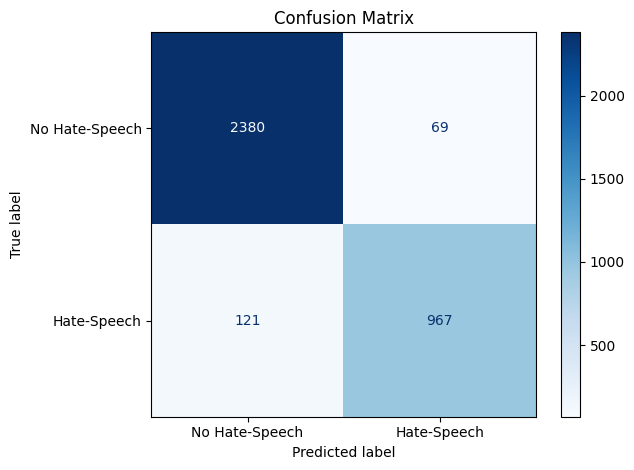

S,█▁
accuracy,█▁
eval/S,▁█▇
eval/accuracy,▁▇█
eval/f1,▁▇█
eval/f2,█▇▁
eval/loss,▁▃█
eval/mcc,▁▇█
eval/mcc_normalized,▁▇█
eval/precision,▁▇█
eval/recall,█▃▁


2025-01-04 22:59:45,013 - INFO - wandb.finish() completed successfully.
2025-01-04 22:59:45,014 - INFO - Model saved to /content/drive/MyDrive/model/BERT_CNN_2025-01-04_22-56-52
2025-01-04 22:59:45,015 - INFO - Process finished and terminated


In [ ]:
all_results = []

# Create distinctive name for wandb run
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = f"BERT_CNN_fixed_params{timestamp}"

# Initialize WandB with a unique run ID
run = wandb.init(
    project="German_Hate_Speech_Classification",
    name=run_name,
    #reinit=True,
    id=run_name
)

# Initialize model
model = BERT_CNN(bert_model_name="deepset/gbert-base", num_labels=2, class_weights=class_weights)
model.to(device)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train and Evaluate
trainer.train()

# Get predictions on val_dataset
predictions = trainer.predict(val_dataset)

eval_metrics = compute_metrics((predictions.predictions, predictions.label_ids))
logger.info(f"Validation Metrics: {eval_metrics}")
wandb.log(eval_metrics)

# Get predictions on test_dataset
test_predictions = trainer.predict(test_dataset)
test_metrics = compute_metrics((test_predictions.predictions, test_predictions.label_ids))
logger.info(f"Test Metrics: {test_metrics}")
wandb.log(test_metrics)

logits, labels = test_predictions.predictions, test_predictions.label_ids
preds = np.argmax(logits, axis=1)
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Hate-Speech", "Hate-Speech"])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()

all_results.append({
    "Trial_Name": run_name,
    "Dataset": dataset_filename,
    **eval_metrics,
    **{f"test_{k}": v for k, v in test_metrics.items()}
})

# Save results to Excel
excel_file_path = "/content/drive/MyDrive/model/logged_model_metrics.xlsx"
if os.path.exists(excel_file_path):
    existing_df = pd.read_excel(excel_file_path, index_col="Trial_Name")
    new_df = pd.DataFrame(all_results)
    new_df.set_index("Trial_Name", inplace=True)
    results_df = pd.concat([existing_df, new_df])
else:
    results_df = pd.DataFrame(all_results)
    results_df.set_index("Trial_Name", inplace=True)

results_df.to_excel(excel_file_path)

# Save model
model_dir = f"/content/drive/MyDrive/model/BERT_CNN_{timestamp}"
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, "model_CNN_fixed_params.bin")
torch.save(model.state_dict(), model_filename)

# Save tokenizer
tokenizer.save_pretrained(model_dir)


# Finish WandB
safe_wandb_finish(timeout=45)
logger.info(f"Model saved to {model_dir}")
logger.info("Process finished and terminated")
time.sleep(5)
runtime.unassign()
